In [2]:
import os
import os.path as op
import json
from pathlib import Path
import shutil
import logging
import numpy as np
from tqdm import tqdm
from sklearn.metrics import classification_report

### 1. (a) Data set import

In [3]:
path = '../data'

In [4]:
# Logging configuration
logging.basicConfig(level=logging.INFO,
                    datefmt='%H:%M:%S',
                    format='%(asctime)s | %(levelname)-5s | %(module)-15s | %(message)s')

IMAGE_SIZE = (299, 299)  # All images contained in this dataset are 299x299 (originally, to match Inception v3 input size)
SEED = 17

# Head directory containing all image subframes. Update with the relative path of your data directory
data_head_dir = Path(path)

# Find all subframe directories
subdirs = [Path(subdir.stem) for subdir in data_head_dir.iterdir() if subdir.is_dir()]
src_image_ids = ['_'.join(a_path.name.split('_')[:3]) for a_path in subdirs]

In [5]:
# Load train/val/test subframe IDs
def load_text_ids(file_path):
    """Simple helper to load all lines from a text file"""
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    return lines

# Load the subframe names for the three data subsets
train_ids = load_text_ids('../train_source_images.txt')
validate_ids = load_text_ids('../val_source_images.txt')
test_ids = load_text_ids('../test_source_images.txt')

# Generate a list containing the dataset split for the matching subdirectory names
subdir_splits = []
for src_id in src_image_ids:
    if src_id in train_ids:
        subdir_splits.append('train')
    elif src_id in validate_ids:
        subdir_splits.append('validate')
    elif(src_id in test_ids):
        subdir_splits.append('test')
    else:
        logging.warning(f'{src_id}: Did not find designated split in train/validate/test list.')
        subdir_splits.append(None)

In [6]:
len(subdir_splits)

414

### 1. (b) Loading and pre processing the data

In [22]:
import random
import tensorflow as tf
from PIL import Image

def load_and_preprocess(img_loc, label):

    def _inner_function(img_loc, label):

        # Convert tensor to native type
        img_loc_str = img_loc.numpy().decode('utf-8')
        label_str = label.numpy().decode('utf-8')

        img = Image.open(img_loc_str).convert('RGB')


        return img, 1 if label_str=='frost' else 0

    # Wrap the Python function
    X, y = tf.py_function(_inner_function, [img_loc, label], [tf.float32, tf.int64])
    X.set_shape((299, 299, 3))
    y.set_shape(())

    return X, y

def load_subdir_data(dir_path, image_size, seed=None):

    """Helper to create a TF dataset from each image subdirectory"""

    # Grab only the classes that (1) we want to keep and (2) exist in this directory
    tile_dir = dir_path / Path('tiles')
    label_dir = dir_path /Path('labels')

    loc_list = []

    for folder in os.listdir(tile_dir):
        if os.path.isdir(os.path.join(tile_dir, folder)):
            for file in os.listdir(os.path.join(tile_dir, folder)):
                if file.endswith(".png"):
                    loc_list.append((os.path.join(os.path.join(tile_dir, folder), file), folder))

    return loc_list

# Loop over all subframes, loading each into a list
tf_data_train, tf_data_test, tf_data_val = [], [], []
tf_dataset_train, tf_dataset_test, tf_dataset_val = [], [], []

# Update the batch and buffer size as per your model requirements
buffer_size = 64
batch_size = 32

for subdir, split in zip(subdirs, subdir_splits):
    full_path = data_head_dir / subdir
    if split=='validate':
        tf_data_val.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='train':
        tf_data_train.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))
    elif split=='test':
        tf_data_test.extend(load_subdir_data(full_path, IMAGE_SIZE, SEED))

random.shuffle(tf_data_train)
img_list, label_list = zip(*tf_data_train)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_train = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_train = tf_dataset_train.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_train = tf_dataset_train.shuffle(buffer_size=buffer_size).batch(batch_size)

random.shuffle(tf_data_val)
img_list, label_list = zip(*tf_data_val)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_val = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_val = tf_dataset_val.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_val = tf_dataset_val.shuffle(buffer_size=buffer_size).batch(batch_size)

random.shuffle(tf_data_test)
img_list, label_list = zip(*tf_data_test)
img_list_t = tf.convert_to_tensor(img_list)
lb_list_t = tf.convert_to_tensor(label_list)

tf_dataset_test = tf.data.Dataset.from_tensor_slices((img_list_t, lb_list_t))
tf_dataset_test = tf_dataset_test.map(load_and_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
tf_dataset_test = tf_dataset_test.shuffle(buffer_size=buffer_size).batch(batch_size)

### 1.(c) Training CNN + MLP

#### 1(c) i. To perform empirical regularization, crop, randomly zoom, rotate, flip, contrast, and translate images in your training set for image augmentation. You can use various tools to do this, including OpenCV.

In [23]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, Callback, ModelCheckpoint
from tensorflow.keras.layers.experimental import preprocessing
from keras.models import load_model
import matplotlib.pyplot as plt

In [24]:
# Define a custom callback for printing progress
class PrintProgressCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        print(f"Epoch {epoch + 1}/{self.params['epochs']} - "
              f"Loss: {logs['loss']:.4f} - "
              f"Accuracy: {logs['accuracy']:.4f} - "
              f"Validation Loss: {logs['val_loss']:.4f} - "
              f"Validation Accuracy: {logs['val_accuracy']:.4f}")

In [25]:
# def _fixup_shape(images, labels):
#     images.set_shape([None, 299, 299, 3])
#     labels.set_shape([None, 2])
#     return images, labels

# tf_dataset_train = tf_dataset_train.map(_fixup_shape)
# tf_dataset_val = tf_dataset_val.map(_fixup_shape)
# tf_dataset_test = tf_dataset_test.map(_fixup_shape)

Epoch 1/20
928/928 [==============================] - ETA: 0s - loss: 29.6481 - accuracy: 0.6903

/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


928/928 [==============================] - 1828s 2s/step - loss: 29.6481 - accuracy: 0.6903 - val_loss: 22.6417 - val_accuracy: 0.4494
Epoch 2/20
928/928 [==============================] - 1865s 2s/step - loss: 2.8998 - accuracy: 0.7652 - val_loss: 5.4383 - val_accuracy: 0.5123
Epoch 3/20
928/928 [==============================] - 1790s 2s/step - loss: 1.7739 - accuracy: 0.7637 - val_loss: 76.5213 - val_accuracy: 0.3272
Epoch 4/20
928/928 [==============================] - 1814s 2s/step - loss: 1.3008 - accuracy: 0.7750 - val_loss: 17.7256 - val_accuracy: 0.3898
Epoch 5/20
928/928 [==============================] - 1832s 2s/step - loss: 1.1952 - accuracy: 0.7813 - val_loss: 1.2163 - val_accuracy: 0.7944
Epoch 6/20
928/928 [==============================] - 1723s 2s/step - loss: 1.2568 - accuracy: 0.7651 - val_loss: 18.9549 - val_accuracy: 0.3218
Epoch 7/20
928/928 [==============================] - 1744s 2s/step - loss: 2.7132 - accuracy: 0.6684 - val_loss: 1.5287 - val_accuracy: 0.354

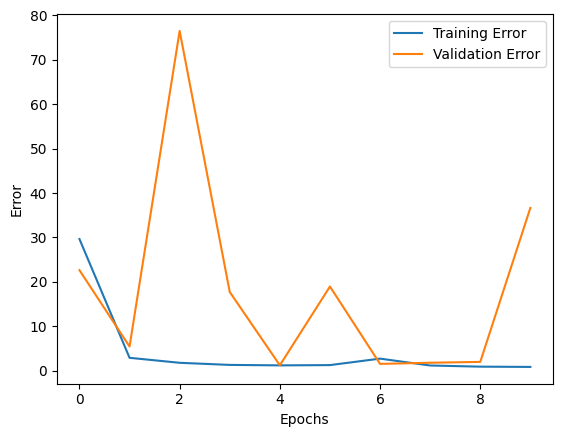

In [26]:
# Set seed for reproducibility
tf.random.set_seed(SEED)

# Define model parameters
kernel_size = (3, 3)
depth = 32
dense_units = 128
dropout_rate = 0.3
l2_regularization = 0.001

# Data augmentation layer
data_augmentation = tf.keras.Sequential([
    preprocessing.Rescaling(1./255),
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomZoom(0.2),
])


# Build the CNN model
cnn_model = models.Sequential()
cnn_model.add(data_augmentation)  # Add data augmentation layer
cnn_model.add(layers.Conv2D(depth, kernel_size, activation='relu', input_shape=(299, 299, 3)))
cnn_model.add(layers.BatchNormalization())
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(depth * 2, kernel_size, activation='relu'))
cnn_model.add(layers.BatchNormalization())
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(depth * 4, kernel_size, activation='relu'))
cnn_model.add(layers.BatchNormalization())
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(dense_units, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_regularization)))
cnn_model.add(layers.Dropout(dropout_rate))
cnn_model.add(layers.Dense(2, activation='softmax'))

# Compile the model
cnn_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Create checkpoint
cnn_model_checkpoint = ModelCheckpoint('cnn_best_model.h5', monitor='val_loss', save_best_only=True)

# Train the model
cnn_history = cnn_model.fit(tf_dataset_train, epochs=20, validation_data=tf_dataset_val, callbacks=[early_stopping, cnn_model_checkpoint]) 

In [28]:
cnn_model.save('cnn_model.keras')

In [27]:
# Best CNN - MLP model
#cnn_model.save('./')
cnn_best_model = load_model('cnn_best_model.h5')

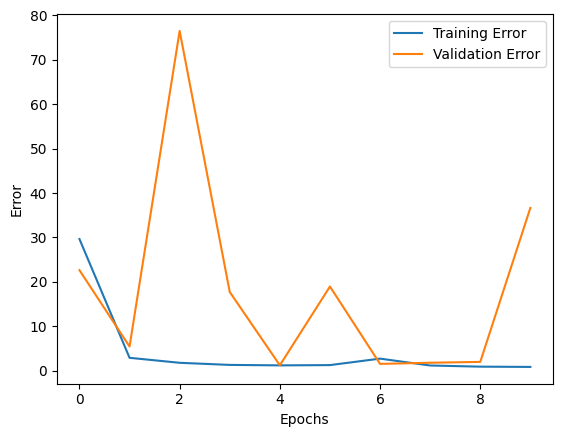

In [30]:
plt.plot(cnn_history.history['loss'], label='Training Error')
plt.plot(cnn_history.history['val_loss'], label='Validation Error')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.show()

In [33]:
y_true = []
y_pred = []

for batch in tf_dataset_test:
    images, labels = batch
    predictions = cnn_model.predict(images)
    
    y_true.extend(labels.numpy())
    y_pred.extend(tf.argmax(predictions, axis=1).numpy())

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate and print classification report
#class_names = ['0', 'class_1']  # Adjust based on your class labels
print(classification_report(y_true, y_pred))

1/1 [==============================] - 0s 326ms/step
              precision    recall  f1-score   support

           0       0.72      0.49      0.59      4418
           1       0.77      0.90      0.83      8405

    accuracy                           0.76     12823
   macro avg       0.75      0.70      0.71     12823
weighted avg       0.76      0.76      0.75     12823



### MODEL PERFORMANCE

                precision    recall  f1-score   support

           0       0.72      0.49      0.59      4418
           1       0.77      0.90      0.83      8405

    accuracy                           0.76     12823
    
    macro avg      0.75      0.70      0.71     12823
   
   
    weighted avg   0.76      0.76      0.75     12823   

## SUMMARY
**CNN Model:**

  > Precision: 0.76
  > Recall: 0.76
  > F1-score: 0.75
  > Accuracy: 0.76

**EfficientNetB0 Transfer Learning:**

  >Precision: 0.57
  Recall: 0.65
  F1-score: 0.53
  Accuracy: 0.65

**ResNet50 Transfer Learning:**

  >Precision: 0.43
  Recall: 0.66
  F1-score: 0.52
  Accuracy: 0.66

**VGG16 Transfer Learning:**

  >Precision: 0.52
  Recall: 0.50
  F1-score: 0.51
  Accuracy: 0.50


*In summary, the CNN model performs the best overall with the highest precision, recall, and F1-score, resulting in the highest accuracy. The EfficientNetB0 Transfer Learning model has a lower performance compared to the CNN model, and ResNet50 Transfer Learning and VGG16 Transfer Learning models have the lowest accuracy among the models listed.*
